In [9]:
# base
import pandas as pd 
import geopandas as gpd
import numpy as np
import zipfile
import os
import datetime
import random

# graph
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns

# ML
from scipy.fft import fft
from sklearn.preprocessing import MinMaxScaler
import pmdarima
import numba
from statsmodels.tsa.api import SARIMAX
from sktime.datatypes import check_raise, convert_to
from sklearn.linear_model import LinearRegression
from sktime.transformations.series.dummies import SeasonalDummiesOneHot

# function
import famDataset
# force reload to not restart jupyter each time
#from importlib import reload
#reload(famDataset)

In [88]:
# ----------------------------- #
# User input
# ----------------------------- #

# Interest species
especeVec = ['Avoine', 'Blé dur', 'Blé tendre', 'Colza', 'Céréales autres',
            'Féverole', 'Lin', 'Légumineuses autres', 'Maïs', 'Orge', 'Pois',
            'Seigle', 'Soja', 'Sorgho', 'Tournesol', 'Triticale']
espece= especeVec[2]

# Endogeneous variable 
variableVec = ['TOTAL_COLLECTE', 'STOCKS', 'STOCKS_DEPOTS', 'ENTREE_DEPOT',
                'SORTIE_DEPOT', 'REPRISE_DEPOT', 'CORRECT_COLLECTE', 'ENTREE',
                'LAG_DIFF', 'SORTIE']
variable= 'SORTIE'

# SARIMAX parameters
# The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters.
# The (P,D,Q,s) order of the seasonal component of the model for the AR parameters, differences, MA parameters.
# trend parameter controlling the deterministic trend polynomial: [*0*,1,0,1]
# it can be extended, but the constant is determined by the serie mean thus fixed to 0, for robustness.

# exog boolean for using monthly dummies

args_sarimax = {'p':1,'d':0,'q':0,'P':1,'D':0,'Q':0,'trend':[0,1,1,0],'exog': True, 'scaling': False}

# Multithreading for sarima inference - double edge sword:
# - on my core i3 with 2 physical core its pointless, CPU are already maxed with apply. 
# - on better CPU its maybe worthwile

multithreading = False # IA created, not tested.

Grid allowing to test:

- the species
- the interest variable (default: SORTIES)
- SARIMA parameters
- Clustering parameters

It must ouput:
- SARIMA average performance: AIC or BIC for each series
- Clustering performance: DWT

In [3]:
#fam = famDataset.famDataset(root_dir=os.getcwd())
#fam.download_raw_data()

In [81]:
# ----------------------------- #
# Load dataset
# ----------------------------- #
fam = famDataset.famDataset(root_dir=os.getcwd())
fam.load_transformed_data(convert_attributes = True, drop_attributes = False, pivot_to_long = False)
fam.load_geometry_data()

fam_data = fam.transformed_data.copy()

# load dataset
df = famDataset.make_sktime_multiindex(fam_data, especes = espece, variable= variable)
#fam_data.head()

# ----------------------------- #
# MinMaxScaler
# ----------------------------- #
def MinMax(x):
    scaled_x = (x - np.min(x)+0.0001)/(np.max(x)-np.min(x))
    return scaled_x

df.groupby('DEP').apply(lambda x: MinMax(x['SORTIE'].droplevel('DEP')))

scaled_df = df.groupby('DEP').apply(MinMax).droplevel(1)

Raw data loading complete
Raw data processed in transformed_data
Geom data loading complete


In [93]:
# ----------------------------- #
# temporal model function
# ----------------------------- #

def fun_ts(y, args_sarimax):
    # fix the period warning
    y.index.freq = 'MS'
    mu_y = np.mean(y) 
    demean_y = (y - mu_y)

    # create seasonal dummies, excluding first month
    if(args_sarimax['exog']):
        transformer = SeasonalDummiesOneHot(freq='M', drop= True)
        X_seas = transformer.fit_transform(y=y, X=None)
    else:
        X_seas = None

    # set it up according to user input
    arima_coef = [args_sarimax['p'],args_sarimax['d'],args_sarimax['q']]

    seas_coef = [args_sarimax['P'],args_sarimax['D'],args_sarimax['Q'],12]

    # sarima model
    model = SARIMAX(endog = demean_y, 
                    exog = X_seas,
                    trend = args_sarimax['trend'],
                    order= arima_coef,
                    seasonal_order= seas_coef)

    # fitting model
    result = model.fit(disp=True, 
                       maxiter = 1000)
    
    print(result.mle_retvals['fopt'])

    # if function doesn't converge, use non-gradient method powell
    if(not result.mle_retvals['converged']):
        result = model.fit(disp=True, 
                           maxiter = 1000, 
                           method = 'powell', 
                           start_params = result.mle_retvals['gopt'], 
                           optim_complex_step = False)
        
        print(result.mle_retvals['fopt'])
        
    # building the result dataframe
    params = result.params

    params['intercept'] = mu_y
    params['aic'] = result.info_criteria('aic')
    params['bic'] = result.info_criteria('bic')
    params['llk'] = result.llf

    r_squared = 1 - (np.sum(result.resid**2, axis = 0) / np.sum((y.values - np.mean(y))**2, axis = 0))
    params['r_squared'] = r_squared

    return(params)


In [94]:
# ----------------------------- #
# Batch launch
# ----------------------------- #

if(args_sarimax['scaling']):
    inf_res = scaled_df['SORTIE'].groupby(level='DEP').apply(lambda g: fun_ts(g.droplevel('DEP'),args_sarimax))
else:
    inf_res = df['SORTIE'].groupby(level='DEP').apply(lambda g: fun_ts(g.droplevel('DEP'),args_sarimax))

10.94492729547318
11.530704983877234
10.27929992554501
7.244841569197156
8.356230281770474


C:\Users\yupan\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4.9532175100334435
Optimization terminated successfully.
         Current function value: 5.716389
         Iterations: 25
         Function evaluations: 4309
5.716388597334148
8.965724502072536
10.633355382070341
9.680439223459524
11.742546315354312
9.276207343440579
9.027895729841573
10.390463571306153
11.532780914885416
6.874288145574254
11.324042657539344
12.11279978585571
11.424817142041102
8.226819542180419
11.364827493668798
11.853157551272414
8.661624136065068
10.095679878285196
9.275040484398588
10.40690391246316
11.651956749933209
11.59111645181448
11.662972525380583
3.890446581154417


C:\Users\yupan\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yupan\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:1488: RuntimeWarning: invalid value encountered in scalar power
  unconstrained[start] = constrained[start]**0.5


6.001914929605334


LinAlgError: Schur decomposition solver error.

In [6]:
# ----------------------------- #
# Convert results to a dataframe
# ----------------------------- #
arr = inf_res.values.reshape(-1, len(inf_res.loc['01']))  
DEPVec = fam_data['DEP'].unique()

df_inf_res = pd.DataFrame(arr, index=pd.Index(DEPVec, name='DEP'), columns= inf_res.loc['01'].index)

df_inf_res

# test:
# all columns are float, except DEP
# r_squared are between 0 and 1


# save
df_inf_res.to_csv(espece.replace(" ", "") + '-inference.csv')



In [7]:
df_inf_res.values
#pd.to_numeric(df_inf_res.iloc[:,1])

#df_inf_res.apply(pd.to_numeric)

array([[ 1.70931347e+01, -7.67089533e-02,  6.55477468e+03, ...,
         6.74715394e+03, -3.32784075e+03,  2.92730206e-01],
       [-3.63605584e+01,  1.67893848e-01, -2.67234418e+03, ...,
         7.10179235e+03, -3.50515995e+03,  2.80322274e-01],
       [ 2.07715818e+00, -7.94908217e-03,  1.34374339e+03, ...,
         6.34227409e+03, -3.12540082e+03,  1.06336913e-01],
       ...,
       [ 2.95629120e-01, -1.82300282e-03,  7.49782397e+01, ...,
         4.34521890e+03, -2.12687323e+03,  4.96255303e-01],
       [ 1.87398171e-01, -1.57098305e-03,  4.68032428e+01, ...,
         4.52728394e+03, -2.21790575e+03,  4.40369685e-01],
       [ 4.62549238e+00, -1.58217621e-02, -2.99559317e+03, ...,
         6.40397969e+03, -3.15625362e+03,  1.57420369e-01]],
      shape=(96, 21))

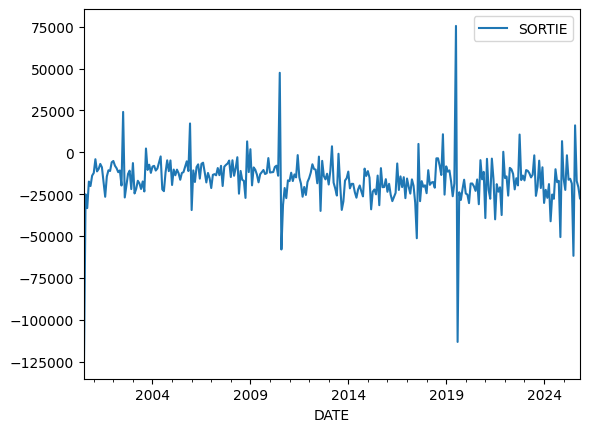

10.979764418195275


drift                    32.417774
trend.2                  -0.169335
Feb                    2245.536131
Mar                     -43.323868
Apr                    1063.688132
May                     817.156132
Jun                   -1995.235866
Jul                    1583.955978
Aug                   -6098.313253
Sep                   -1881.513253
Oct                     871.879055
Nov                    -352.247868
Dec                    4714.072132
ar.L1                    -0.220917
ar.S.L12                  0.035895
sigma2            158728391.425095
intercept            -16174.652131
aic                    6729.656295
bic                    6789.181284
llk                   -3348.828148
r_squared    [0.07305603647914405]
dtype: object

In [83]:
y = df.loc['31']

y.plot()
plt.show()

fun_ts(y, args_sarimax)


In [9]:
# fix the period warning
y.index.freq = 'MS'

# create seasonal dummies, excluding first month
if(args_sarimax['exog']):
    transformer = SeasonalDummiesOneHot(freq='M', drop= True)
    X_seas = transformer.fit_transform(y=y, X=None)
else:
    X_seas = None

# set it up according to user input
arima_coef = [args_sarimax['p'],args_sarimax['d'],args_sarimax['q']]

seas_coef = [args_sarimax['P'],args_sarimax['D'],args_sarimax['Q'],12]

# sarima model
model = SARIMAX(endog = y, 
                exog = X_seas,
                trend = args_sarimax['trend'],
                order= arima_coef,
                seasonal_order= seas_coef)

# fitting model
result = model.fit(disp=True, maxiter = 1000)
print(result.mle_retvals['fopt'])

# if function doesn't converge, use non-gradient method powell
if(not result.mle_retvals['converged']):
    result = model.fit(disp=True, maxiter = 1000, method = 'powell', start_params = result.mle_retvals['gopt'])
    print(result.mle_retvals['fopt'])
    
# building the result dataframe
params = result.params

params['aic'] = result.info_criteria('aic')
params['bic'] = result.info_criteria('bic')
params['llk'] = result.llf

r_squared = 1 - (np.sum(result.resid**2, axis = 0) / np.sum((y.values - np.mean(y))**2, axis = 0))
params['r_squared'] = r_squared

params

11.019147466086


drift                      9.353955
trend.2                   -0.094386
Feb                   -13929.116002
Mar                   -16217.975997
Apr                   -15110.963997
May                   -15357.495997
Jun                   -18169.887996
Jul                   -14590.696152
Aug                   -22272.965382
Sep                   -18056.165382
Oct                   -15301.669228
Nov                   -16087.787998
Dec                   -11460.580002
ar.L1                     -0.219633
ar.S.L12                   0.154818
sigma2             180255531.641689
aic                     6731.641659
bic                     6791.114103
llk                     -3349.82083
r_squared    [-0.01308144611127049]
dtype: object

In [10]:
# ----------------------------- #
# clustering
# ----------------------------- #